In [101]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

#my libraries
import sys
sys.path.append("../code")

import myUtilities

import importlib
importlib.reload(myUtilities)


<module 'myUtilities' from 'd:\\education\\sem 9 SIGMA\\convex optimization\\lab 3\\notebooks\\../code\\myUtilities.py'>

In [102]:
#parameters
image_name = "peanuts"
image_path = f"../resources/{image_name}.png"
seed = 42
noise_ratio = 0.5
dimension = 256
kernel_size = 3

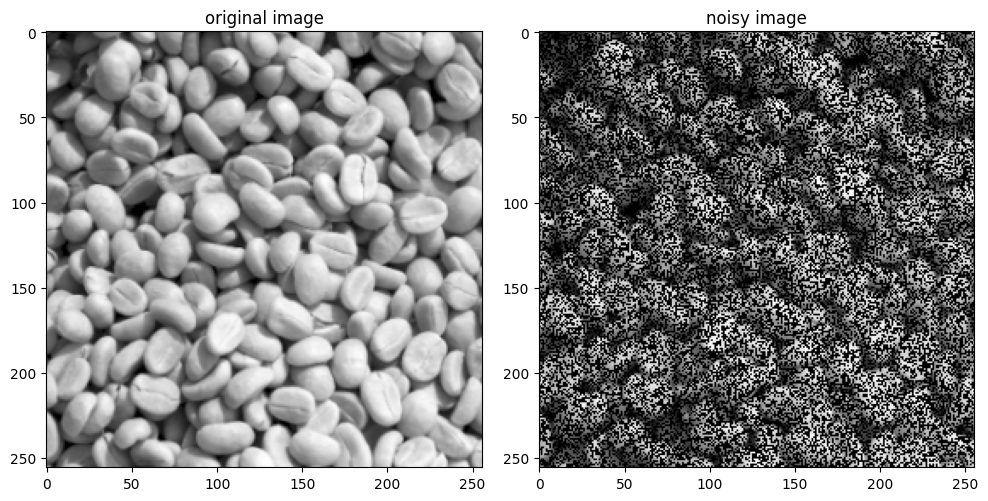

In [103]:
#import the original 
img_OG = cv.resize(cv.imread(image_path,0) , (dimension,dimension))

#add noise
dim = img_OG.shape[0] #image dimension for one axis
noise_indeces = myUtilities.define_noise_mask(dim,noise_ratio,seed = seed)
img_noisy = myUtilities.mask_Image(img_OG,noise_indeces)

#plot original and noisy image

fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # figsize adjusts the overall figure size

ax[0].imshow(img_OG,'gray')
ax[0].set_title('original image')

ax[1].imshow(img_noisy,'gray')
ax[1].set_title('noisy image')

plt.tight_layout()
plt.show()

using a median filter to initialise the DR method

In [104]:
def apply_kernel(image,kernel_size):
    # Get image dimensions
    rows, cols = image.shape
    
    # Create an output image of the same size
    output_image = np.zeros_like(image)
    
    # Define kernel size
    pad = kernel_size // 2
    
    # Iterate over each pixel in the image
    for i in range(pad, rows - pad):
        for j in range(pad, cols - pad):
            # Extract the 5x5 neighborhood (kernel) around the current pixel
            neighborhood = image[i - pad:i + pad + 1, j - pad:j + pad + 1]
            
            # Flatten the neighborhood into a 1D array and remove zeros
            non_zero_values = neighborhood[neighborhood != 0]
            
            # If no non-zero values, retain the original pixel (or handle as needed)
            if non_zero_values.size == 0:
                median_value = 0
            else:
                # Calculate the median of the non-zero values
                median_value = np.median(non_zero_values)
            
            # Set the output pixel to the computed median
            output_image[i, j] = median_value
    
    return output_image


In [105]:
#testing the method
temp = apply_kernel(img_noisy,kernel_size)
img_med_init = myUtilities.fill_zero(np.abs(temp / np.max(temp)))

Rachford method

In [106]:
#inner parameters and variables to use in the implementaion
def fft2d(input_array):
    """Perform 2D FFT (Fast Fourier Transform)"""
    return np.fft.fft2(input_array)

def ifft2d(input_array):
    """Perform 2D IFFT (Inverse Fast Fourier Transform)"""
    return np.fft.ifft2(input_array)


img_given = img_noisy

mask_indx = noise_indeces
mask_indx_inv = myUtilities.invert_mask(dimension, noise_indeces)

init_fft = fft2d(img_med_init)

x0 = np.abs(init_fft)
phase = np.angle(init_fft)

ro = 0.6
gamma = 5

In [107]:
import numpy as np


def prox_f(x, gamma):
    """
    Proximity operator for the function f.
    """
    # Proximal operator of l1-norm (for sparsity problems)
    return np.sign(x) * np.maximum(0, np.abs(x) - gamma)


def prox_g(x,y,inv_mask_indeces):
    """
    Proximity operator for the function g.
    """
    # Proximal operator of the indicator function for Ax = y

    #comput x_sp the ifft of x    
    x_sp = np.abs(ifft2d(x * np.exp(1j * phase)))
    x_sp /= np.max(x_sp)

    y = y.astype(float)
    y /= np.max(y)
    
    #set the values of x_sp to the given image
    x_sp = myUtilities.reset_pixels(y,x_sp,inv_mask_indeces)
    #comput and return x the ifft of x_sp
    x = np.abs(fft2d(x_sp))
    return x

NMSE_values = []
def douglas_rachford(f, g, x0, ro, gamma,x_OG, max_iter=1000, tol=1e-6):
    """
    Douglas-Rachford algorithm for minimizing f(x) + g(x)

    Parameters:
    - f, g: Functions for which we want to compute the proximity operators
    - x0: Initial guess
    - ro: Step size (also known as the proximity parameter)
    - max_iter: Maximum number of iterations
    - tol: Convergence tolerance

    Returns:
    - x: Solution to the problem
    """
    xk = x0
    xk_wave = xk    
    for i in range(max_iter):
        # Apply proximity operator for f
        xk_wave =  prox_f(xk, gamma)        
        # Apply proximity operator for g
        xk = xk +  2 * ro * (prox_g(2 * xk_wave - xk , img_given, mask_indx_inv) - xk_wave)
          
    
        # Check for convergence        
        denoised_img = np.abs(ifft2d(xk * np.exp(1j * phase)))
        NMSE_values.append(myUtilities.NMSE(x_OG / np.max(x_OG),denoised_img / np.max(denoised_img)))        
        if(len(NMSE_values) >1):
            if(np.abs(NMSE_values[-1] - NMSE_values[-2] )< tol):
                print("convergence at :",i," iterations")
                return xk,NMSE_values
        
    print("Maximum iterations reached")
    return xk,NMSE_values

Maximum iterations reached


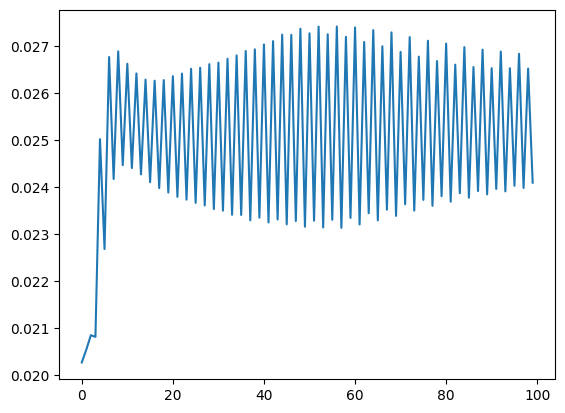

In [108]:
#algorithm testing
x_star,NMSE_values = douglas_rachford(prox_f, prox_g, x0, ro, gamma,img_OG, max_iter=100, tol=1e-5)
fft_result = x_star * np.exp(1j * phase)
ifft_result = ifft2d(fft_result)

img_filtered = np.abs(ifft_result)
plt.plot(NMSE_values)
np.save(f'../arrays/NMSE_{image_name}_{dimension}_{noise_ratio}_BSDR',NMSE_values)

showing the result

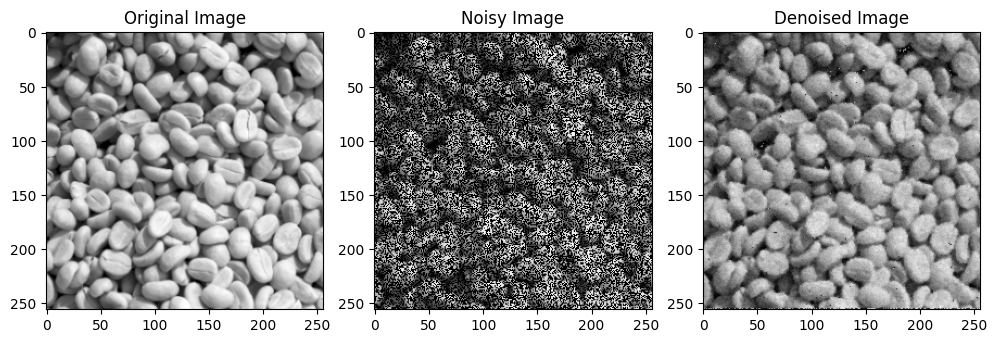

In [109]:
# Create the figure and subplots
fig, ax = plt.subplots(1, 3, figsize=(10, 5))  # figsize adjusts the overall figure size

# Plot original, noisy, and reconstructed (filtered) images
im1 = ax[0].imshow(img_OG, cmap='gray')
ax[0].set_title('Original Image')
#plt.colorbar(im1, ax=ax[0])  # Add color bar for the first subplot

im2 = ax[1].imshow(img_noisy, cmap='gray')
ax[1].set_title('Noisy Image')
#plt.colorbar(im2, ax=ax[1])  # Add color bar for the second subplot

im3 = ax[2].imshow(img_filtered, cmap='gray')
ax[2].set_title('Denoised Image')
#plt.colorbar(im3, ax=ax[2])  # Add color bar for the third subplot

# Adjust layout
plt.tight_layout()
plt.show()


In [110]:
regulized_image = (img_filtered * 255).astype(np.uint8)
cv.imwrite(f'../tests/{image_name}_{dimension}_{noise_ratio}_BSDR.jpeg',regulized_image)

True